# Exploration of movie genre dataset image
- You can download the dataset https://www.kaggle.com/neha1703/movie-genre-from-its-poster?select=SampleMoviePosters
- It contains a combination of a single image poster, with multiple labels
- e.g a moview can be both action, comedy and romance combined

In [11]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import glob
from sklearn.preprocessing import MultiLabelBinarizer
import os

# Utility function

In [2]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

# Load and visualize data

In [3]:
df = pd.read_csv('data/MovieGenre.csv')

In [4]:
df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


In [5]:
df = df.dropna()

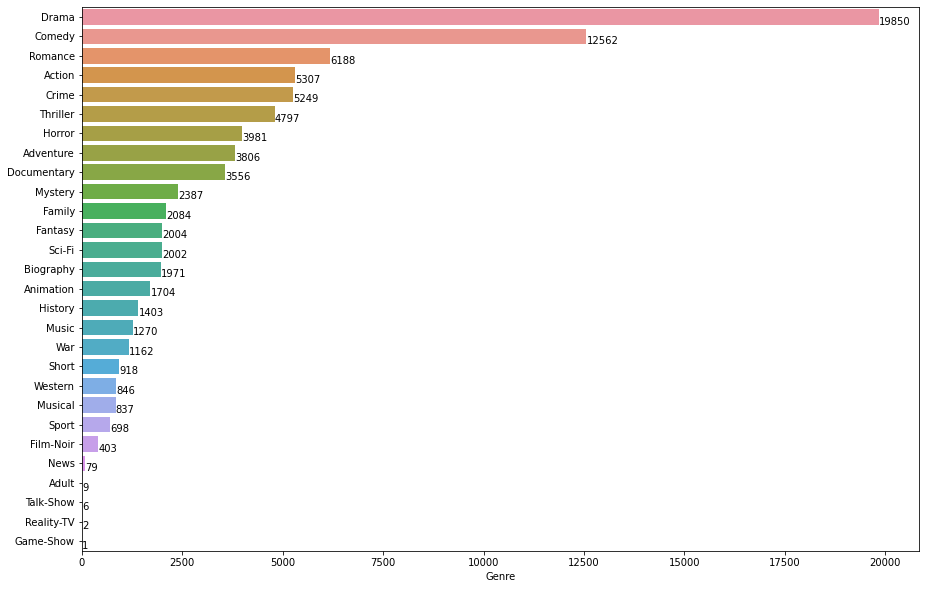

In [6]:
# View class distribution
count_vals = df['Genre'].apply(lambda x: x.split('|')).explode().value_counts()

plt.figure(figsize=(15, 10))
g = sns.barplot(y=count_vals.index, x=count_vals)
show_values_on_bars(g, "h", 3.3)

# Lets read and understand the images
- We have to download our images
- At the same time we have to binarize our labels to as such -> [0, 1, 1, 0]
- Classification problems type:

    1) Multi class classification - can only be 1 labelt
        - one_hot_example -> [0, 1, 0, 0] # cannot be more than 1 type
        - output - softmax (probability of whether you belong to 1 class)
            - [0.3, 0.6, 0.05, 0.05] - Add to become 1
        
    2) Multi label classification - can be more than 1 label
        - one_hot_example -> [1, 1, 0, 0] # can be more than 1 type
        - output - sigmoid function (probablity add up to be more than 1, each class also have a value of 0 - 1)
            - [0.7, 0.8, 0.3, 0.2] - Can add up to be more than 1

In [77]:
def multilabel_onehot(labels, classes=28):
    return tf.reduce_max(tf.one_hot(labels, classes), axis=0)

In [81]:
images = glob.glob('data/downloaded_posters/*.jpg')

In [100]:
label_index = dict([(key, index) for index, key in enumerate(list(count_vals.keys()))])
index_label = dict([(index, key) for index, key in enumerate(list(count_vals.keys()))])

In [83]:
labels = []
remove_index = []
for index, image in enumerate(images):
    image_name = os.path.splitext(os.path.basename(image))[0]
    selected_df = df.loc[df['imdbId'] == int(image_name)]
    if len(selected_df) > 0:
        genres = selected_df.iloc[0]['Genre']
        genre_label = []
        for genre in genres.split('|'):
            genre_label.append(label_index[genre])
        labels.append(multilabel_onehot(genre_label))
    else:
        remove_index.append(index)

In [85]:
for i in remove_index:
    del images[i]

In [86]:
dataset = tf.data.Dataset.from_tensor_slices((images, labels))

In [88]:
@tf.function
def decode_data(image, label):
    img = tf.io.decode_jpeg(tf.io.read_file(image))
    return img, label

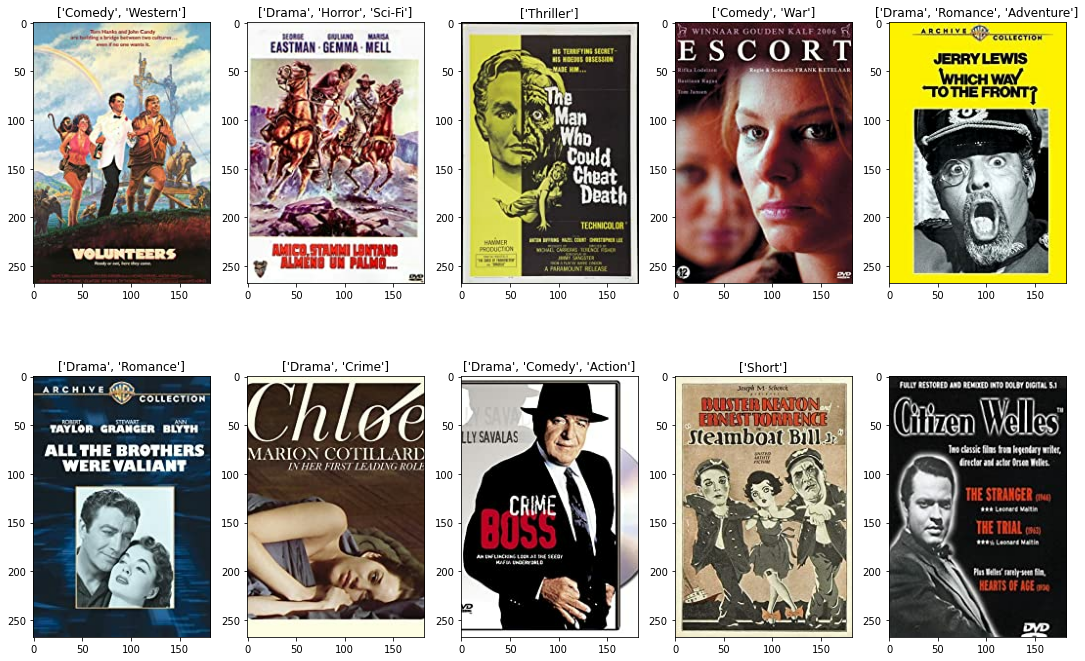

In [106]:
row, column, count = 2, 5, 0
plt.figure(figsize=(15, 10))
for image, label in dataset.shuffle(1024).map(decode_data).take(10):
    count += 1
    titles = [index_label[i] for i in tf.where(label == 1).numpy().ravel()]
    plt.title(titles)
    plt.subplot(row, column, count)
    plt.imshow(image)
    
plt.tight_layout()